In [1]:
from IPython.display import Image, display, clear_output
import os
import torch
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import time
import sklearn
import colorcet as cc

from typing import *
from collections import defaultdict
from warnings import simplefilter
from umap import UMAP

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.binomial import Binomial
from torch.distributions.log_normal import LogNormal
from torch.utils.data import random_split, DataLoader, Subset

# Model for encoding

### Model functions

In [2]:
class HurdleNormal(Distribution):
    """
    A hurdle model of the Bernoulli and normal distributions to model data which is normally distributed with an excess probability mass at 0
    Hurdle Normal PDF:
    p(x | mu, sigma, p) = p for x=0
    p(x | mu, sigma, p) = (1-p) * normal distribution pdf
    This is to be used as observation model p(x|z): p(x | z, mu, sigma, p)
    """
    def __init__(self, mu:Tensor, log_sigma:Tensor, p_logits:Tensor):
        assert mu.shape == log_sigma.shape == p_logits.shape, f"Tensors 'mu': {mu.shape}, 'log_sigma': {log_sigma.shape} and 'p': {p_logits.shape} must be of the same shape."
        self.mu = mu
        self.sigma = log_sigma.exp() + 0.01 # to avoid sigma being zero
        self.p_logits = p_logits

        self.Bernoulli = torch.distributions.bernoulli.Bernoulli(logits = self.p_logits)
        
        odds = p_logits.exp()
        prob = odds / (1+odds)
        self.prob = prob
        
    def sample(self) -> Tensor:
        """sample `x ~ hurdle_normal(x | mu, sigma, p)`"""
        
        with torch.no_grad():
            # Bernoulli returns either 0 or 1, and for 1 we want the value from the sampled log_normal distribution so we just multiply them
            B = self.Bernoulli.sample() 
            norm = torch.distributions.normal.Normal(self.mu, self.sigma).sample()
            return B*norm
            
    def log_prob(self, x:Tensor) -> Tensor:
        """
        return log probability: log p(x)
        for x=0:
            p(x|mu, sigma, p) = p 
        for x > 0
            p(x|mu, sigma, p) = (1-p) * 1 / (sigma * sqrt(2*pi)) * exp(-0.5 * ((x - mu) / sigma)) 
        """
        
        idx = x > 0.
        
        # Log prob of zero values = log p
        # Using torch.zeros as for the places where x is not 0 we want (1-p)
        bernoulli_tensor = torch.zeros_like(x)
        bernoulli_tensor[idx] = 1.
        
        log_prob_bernoulli = self.Bernoulli.log_prob(bernoulli_tensor)
        
        # assert idx.sum().item() == len(x[idx])
        
        log_prob_normal = torch.distributions.normal.Normal(loc = self.mu[idx], scale = self.sigma[idx]).log_prob(x[idx])
        log_prob_normal = torch.zeros_like(log_prob_bernoulli).masked_scatter(idx, log_prob_normal)
        
        # FINAL LOG PROB
        log_p = log_prob_bernoulli + log_prob_normal # Log prob will be log(p) when x=0 and log(p-1) + logprob_normal when x>0

        return log_p

In [3]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp() + 0.001
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon() 
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return torch.distributions.normal.Normal(self.mu, self.sigma).log_prob(z)

    def __repr__(self):
        return f"ReparameterizedDiagonalGaussian(mu={self.mu.shape}, sigma={self.sigma.shape})"

In [7]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int, encoder_layer_sizes:list, decoder_layer_sizes:list) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        # ------------------------------------------------------------------------------
        # Defining parameters of model
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        
        self.encoder_layer_sizes = encoder_layer_sizes
        self.n_encoder_layers = len(encoder_layer_sizes)
        
        self.decoder_layer_sizes = decoder_layer_sizes
        self.n_decoder_layers = len(decoder_layer_sizes)
        

        # ------------------------------------------------------------------------------
        # Defining flexible encoder
        encoder_layers = [nn.Linear(self.observation_features, self.encoder_layer_sizes[0]), nn.BatchNorm1d(self.encoder_layer_sizes[0])] # input layer
        encoder_layers.append(nn.LeakyReLU()) # Make it non-linear
        for i in range(self.n_encoder_layers-1):
            encoder_layers.append(nn.Linear(self.encoder_layer_sizes[i], self.encoder_layer_sizes[i+1]))
            encoder_layers.append(nn.BatchNorm1d(self.encoder_layer_sizes[i+1]))
            encoder_layers.append(nn.LeakyReLU())
        encoder_layers.append(nn.Linear(self.encoder_layer_sizes[-1], self.latent_features*2)) # output layer
        
        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(*encoder_layers)
        
        # ------------------------------------------------------------------------------
        # Defining flexible decoder
        decoder_layers = [nn.Linear(self.latent_features, self.decoder_layer_sizes[-1]), nn.BatchNorm1d(self.decoder_layer_sizes[-1])] # input layer
        decoder_layers.append(nn.LeakyReLU())
        for i in range(self.n_decoder_layers-1, 0, -1):
            decoder_layers.append(nn.Linear(self.decoder_layer_sizes[i], self.decoder_layer_sizes[i-1]))
            decoder_layers.append(nn.BatchNorm1d(self.decoder_layer_sizes[i-1]))
            decoder_layers.append(nn.LeakyReLU())
        decoder_layers.append(nn.Linear(self.decoder_layer_sizes[0], self.observation_features*3)) # output layer
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(*decoder_layers)

        # ------------------------------------------------------------------------------
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features]))) # defines a model state variable, which is not learnable
        
    # ------------------------------------------------------------------------------
    # Distributions
    # ------------------------------------------------------------------------------
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        h_x = self.encoder(x) # compute the parameters of the posterior
        mu, log_sigma =  h_x.chunk(2, dim=-1) # splits h_x (which contains both both mean and std values) into 2 chunks along dim=-1
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:]) # The * unpacks the tuple that -shape returns so that we return each element in the tuple instead (opposite of zip operation)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_params = self.decoder(z)
        px_mu, log_px_sigma, px_logit = px_params.chunk(3, dim=-1)
        
        return HurdleNormal(px_mu, log_px_sigma, px_logit)
        
    # ------------------------------------------------------------------------------
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


### Load data

In [8]:
GTEX_DATA_PATH = os.getcwd()+"/Data/gtex_gene_expression.npy"

In [9]:
gtex_data = np.load(GTEX_DATA_PATH)
inputs = torch.from_numpy(gtex_data)

In [10]:
gtex_data_loader = DataLoader(dataset = inputs, 
                       batch_size = 256, 
                       shuffle = False,
                       num_workers=4, 
                       pin_memory=True)

In [11]:
# Only used to get shape of data
data_shaper = next(iter(gtex_data_loader))

In [12]:
data_shaper.shape

torch.Size([256, 34557])

In [13]:
# Set to run on CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

>> Using device: cuda:0


### Load model

In [14]:
MODEL_PARAMETERS_PATH = os.getcwd()+"/Model/VAE_TRAINED_ON_FULL_ARCHS4.pth"

In [15]:
config = {'latent_features':64, 
          'encoder_layer_sizes': [4096, 16384, 4096], 
          'decoder_layer_sizes': [4096, 16384, 4096], 
          'lr': 1e-5}

vae = VariationalAutoencoder(data_shaper[0].shape,
                                 config['latent_features'], 
                                 config['encoder_layer_sizes'], 
                                 config['decoder_layer_sizes'])


vae.load_state_dict(torch.load(MODEL_PARAMETERS_PATH), strict=False)

vae = vae.to(device)

## Model inference

In [16]:
vae.eval()

xs = []
zs = []
pxs = []


for x in gtex_data_loader:
    
    # Inference happens on gpu if available
    x = x.to(device)
    
    outputs = vae(x)
    
    x = x.cpu()
    
    px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
    
    z = z.cpu()
    px = px.sample().cpu()
    
    zs.append(z)
    pxs.append(px)
    xs.append(x)


In [17]:
# Making a torch.tensor with all the original samples
data_samples = torch.zeros(0,34557)
for x in xs:
    data_samples = torch.cat((data_samples, x),0)
data_samples = data_samples.detach().numpy()

In [18]:
# Making a torch.tensor with all the encoded samples
latent_out = torch.zeros(0,64)
for z in zs:
    latent_out = torch.cat((latent_out, z),0)
latent_out = latent_out.detach().numpy()

In [19]:
# Making a torch.tensor with all the reconstructed samples
reconstructions = torch.zeros(0,34557)
for px in pxs:
    reconstructions = torch.cat((reconstructions, px),0)
reconstructions = reconstructions.detach().numpy()

#### Output to file

In [20]:
#np.save(os.getcwd() + "/Data/gtex_gene_expression_encoded.npy", latent_out)

## Check that reconstructions look good and that z looks normally distributed

#### Data annotations

In [21]:
GTEX_FOR_LABELS = os.getcwd()+"/Data/iso_02456/gtex_gene_expression.tsv"
GTEX_TISSUE_ANNOTATIONS_PATH = os.getcwd()+"/Data/iso_02456/gtex_annot.tsv"

In [22]:
file = open(GTEX_FOR_LABELS)

colnames = file.readline().split("\t")
colnames = [i.replace('\n','') for i in colnames]

file.close()

In [23]:
tissues_dict = {}
with open(GTEX_TISSUE_ANNOTATIONS_PATH) as f:
    for line in f:
        (key,val) = line.split("\t")
        tissues_dict[key] = val
        
tissue = []
for sample in colnames:
    tissue.append(tissues_dict[sample])
tissue = [i.replace('\n','') for i in tissue]

In [24]:
for i in range(len(tissue)):
    if 'Adipose' in tissue[i]:
        tissue[i] = 'Adipose'
    elif 'Artery' in tissue[i]:
        tissue[i] = 'Artery'
    elif 'Brain' in tissue[i]:
        tissue[i] = 'Brain'
    elif 'Cervix' in tissue[i]:
        tissue[i] = 'Genitals - female'
    elif 'Colon' in tissue[i]:
        tissue[i] = 'Gastro-intestinal'
    elif 'Heart' in tissue[i]:
        tissue[i] = 'Heart'
    elif 'Esophagus' in tissue[i]:
        tissue[i] = 'Gastro-intestinal'
    elif 'Fallopian' in tissue[i]:
        tissue[i] = 'Genitals - female'
    elif 'Kidney' in tissue[i]:
        tissue[i] = 'Kidney'
    elif 'Ovary' in tissue[i]:
        tissue[i] = 'Genitals - female'
    elif 'Pituitary' in tissue[i]:
        tissue[i] = 'Brain'
    elif 'Small Intestine' in tissue[i]:
        tissue[i] = 'Gastro-intestinal'
    elif 'Skin' in tissue[i]:
        tissue[i] = 'Skin'
    elif 'Stomach' in tissue[i]:
        tissue[i] = 'Gastro-intestinal'
    elif 'Vagina' in tissue[i]:
        tissue[i] = 'Genitals - female'

In [25]:
set(tissue)

{'Adipose',
 'Adrenal Gland',
 'Artery',
 'Bladder',
 'Brain',
 'Breast - Mammary Tissue',
 'Cells - Cultured fibroblasts',
 'Cells - EBV-transformed lymphocytes',
 'Gastro-intestinal',
 'Genitals - female',
 'Heart',
 'Kidney',
 'Liver',
 'Lung',
 'Minor Salivary Gland',
 'Muscle - Skeletal',
 'Nerve - Tibial',
 'Pancreas',
 'Prostate',
 'Skin',
 'Spleen',
 'Testis',
 'Thyroid',
 'Uterus',
 'Whole Blood'}

In [26]:
len(set(tissue))

25

#### Plotting encoded data distribution & reconstruction

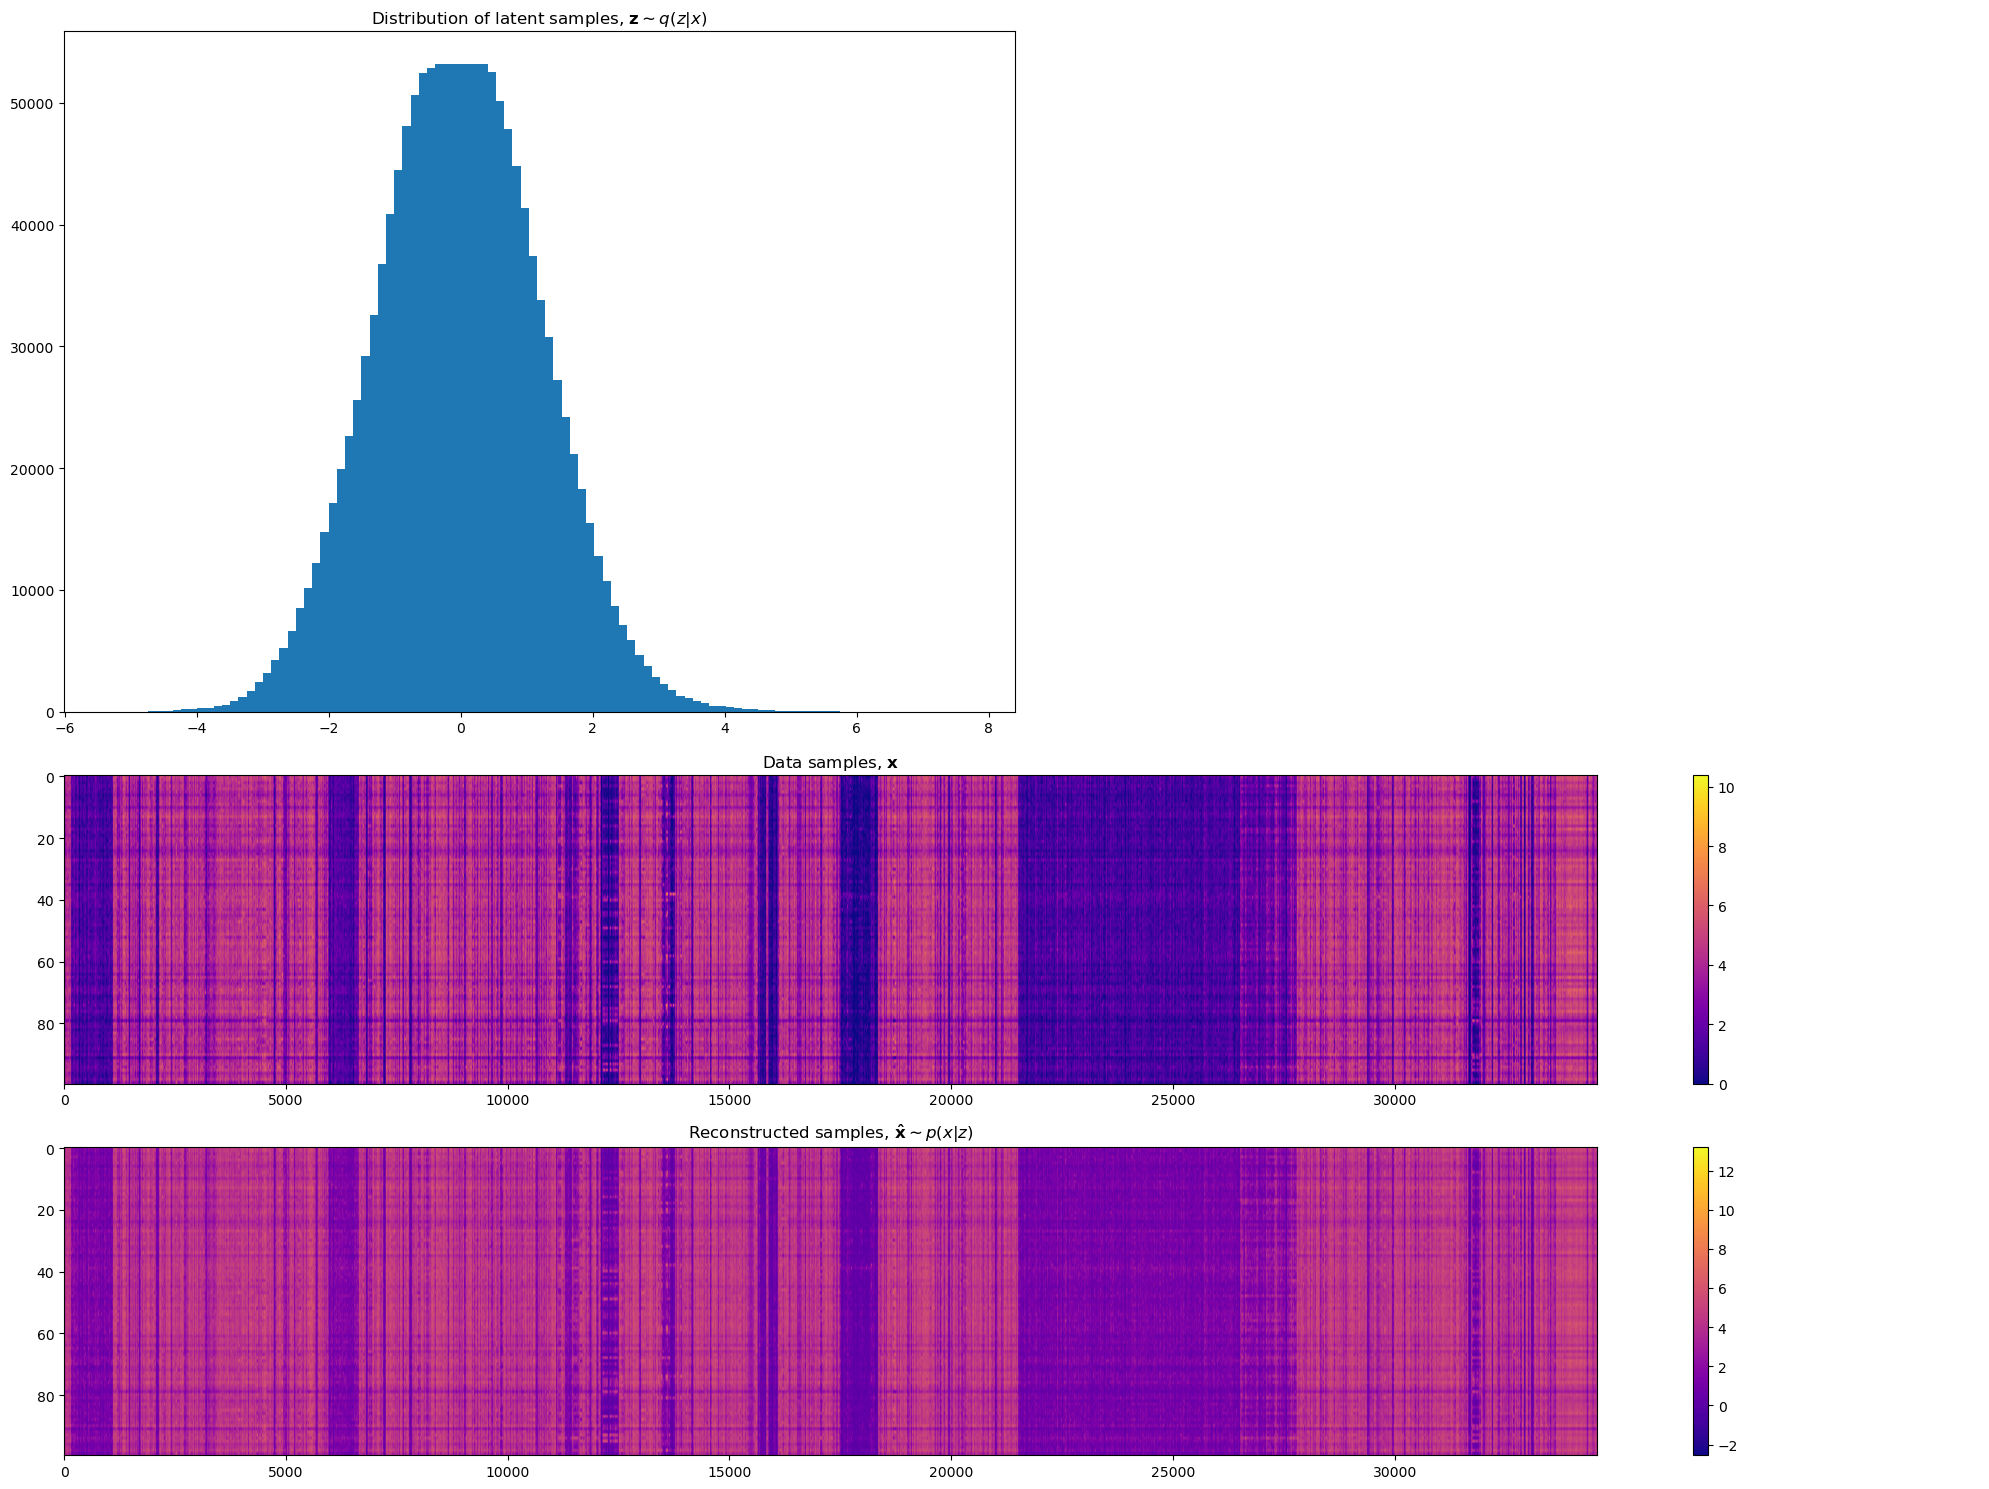

In [27]:
simplefilter(action='ignore')

# Sample N random samples & reconstructions to plot
N = 100
idx = np.random.randint(data_samples.shape[0], size=N)


hist,bin_edges = np.histogram(latent_out, bins=100)

fig, axes = plt.subplot_mosaic([['dist', 'none'],
                                ['dist', 'none'],
                                ['samples', 'samples'], 
                                ['reconstructions', 'reconstructions']])

fig.set_size_inches(20, 15)

# plot latent sample (z) distribution
axes['dist'].set_title(r"Distribution of latent samples, $\mathbf{z} \sim q(z|x)$")
axes['dist'].bar(np.arange(latent_out.min(), latent_out.max(), (latent_out.max()-latent_out.min())/100), hist)


# plot data samples heatmap
axes['samples'].set_title(r"Data samples, $\mathbf{x}$")
a = axes['samples'].imshow(data_samples[idx], cmap="plasma", aspect="auto")
plt.colorbar(a, ax = axes['samples'], location='right')

# plot reconstructions heatmap
axes['reconstructions'].set_title(r"Reconstructed samples, $\mathbf{\hat x} \sim p(x|z)$")
b = axes['reconstructions'].imshow(reconstructions[idx], cmap="plasma", aspect="auto")
plt.colorbar(b, ax = axes['reconstructions'], location='right')

axes['none'].set_axis_off()

plt.tight_layout()
plt.show()

#### UMAP dimensionality reduction for plotting latent space

In [28]:
umap_2d = UMAP(n_components=2, init='random', random_state=0)

In [29]:
# UMAP projection of 64-dimensional VAE encodings to 2 dimensions for plotting
proj_gtex_genes_vae_encoded = umap_2d.fit_transform(latent_out)

In [31]:
# UMAP projection of 34558-dimensional raw data to 2 dimensions for plotting
gtex_genes_unencoded = np.loadtxt(os.getcwd() + "/Data/iso_02456/gtex_gene_expression.tsv", dtype=np.float32, delimiter='\t', skiprows=1)
gtex_genes_unencoded = gtex_genes_unencoded.T
proj_gtex_genes_unencoded = umap_2d.fit_transform(gtex_genes_unencoded)

In [32]:
# UMAP projection of 64-dimensional PCA encodings to 2 dimensions for plotting
gtex_genes_pca_encoded = np.load(os.getcwd() + "/Data/gtex_gene_express_pca_64.npy")
proj_gtex_genes_pca_encoded = umap_2d.fit_transform(gtex_genes_pca_encoded)

In [33]:
# Dataframes with annotations for plotting

proj_gtex_genes_vae_encoded = pd.DataFrame(proj_gtex_genes_vae_encoded, index=colnames)
proj_gtex_genes_vae_encoded = proj_gtex_genes_vae_encoded.rename(columns={0: "UMAP1", 1: "UMAP2"})
proj_gtex_genes_vae_encoded['tissue'] = tissue

proj_gtex_genes_unencoded = pd.DataFrame(proj_gtex_genes_unencoded, index=colnames)
proj_gtex_genes_unencoded = proj_gtex_genes_unencoded.rename(columns={0: "UMAP1", 1: "UMAP2"})
proj_gtex_genes_unencoded['tissue'] = tissue

proj_gtex_genes_pca_encoded = pd.DataFrame(proj_gtex_genes_pca_encoded, index=colnames)
proj_gtex_genes_pca_encoded = proj_gtex_genes_pca_encoded.rename(columns={0: "UMAP1", 1: "UMAP2"})
proj_gtex_genes_pca_encoded['tissue'] = tissue

Text(0.5, 0.98, 'GTEX VAE encoded data')

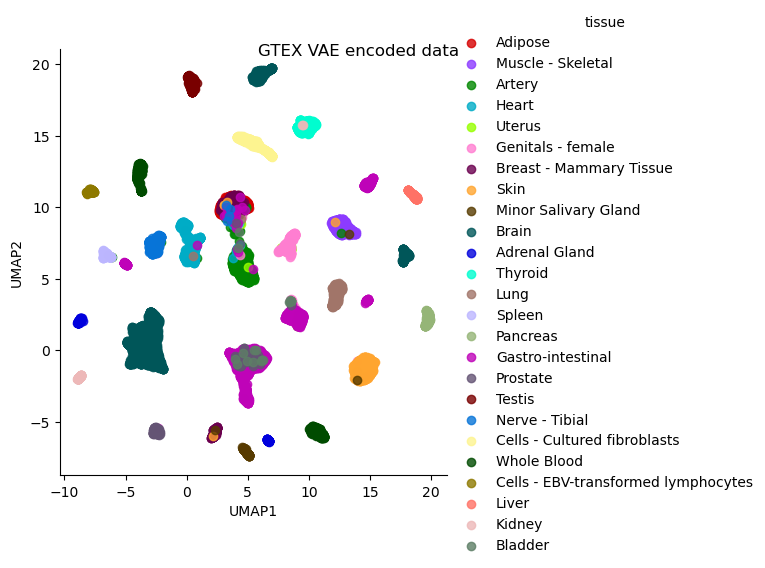

In [45]:
# GTEX VAE encoded data
plot_gtex_encoded = sns.lmplot(x='UMAP1', y='UMAP2', data=proj_gtex_genes_vae_encoded, fit_reg=False, hue='tissue', legend=True, palette=sns.color_palette(cc.glasbey, n_colors=25))
fig = plot_gtex_encoded.fig
fig.suptitle("GTEX VAE encoded data")
# plt.savefig(os.getcwd()+"/Figures/UMAP_VAE.png", dpi=300)

Text(0.5, 0.98, 'GTEX raw data')

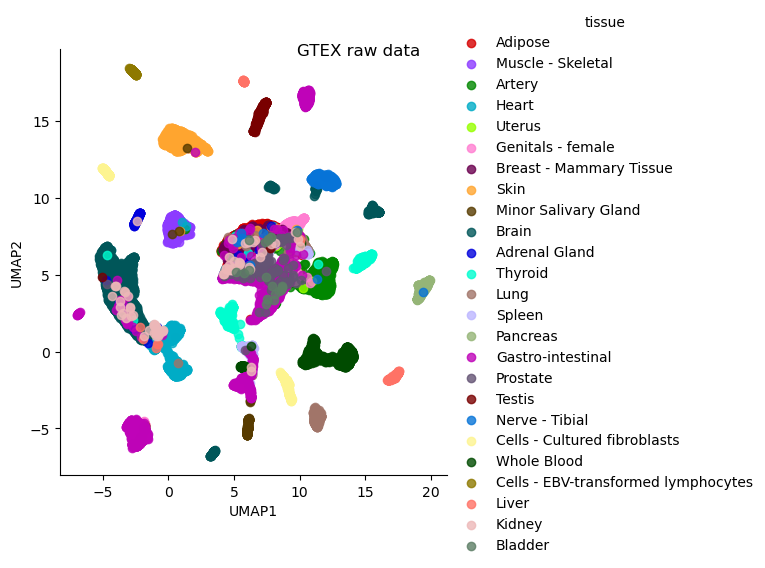

In [46]:
# GTEX raw data
plot_gtex_encoded = sns.lmplot(x='UMAP1', y='UMAP2', data=proj_gtex_genes_unencoded, fit_reg=False, hue='tissue', legend=True, palette=sns.color_palette(cc.glasbey, n_colors=25))
fig = plot_gtex_encoded.fig
fig.suptitle("GTEX raw data")
# plt.savefig(os.getcwd()+"/Figures/UMAP_raw.png", dpi=300)

Text(0.5, 0.98, 'GTEX PCA encoded data')

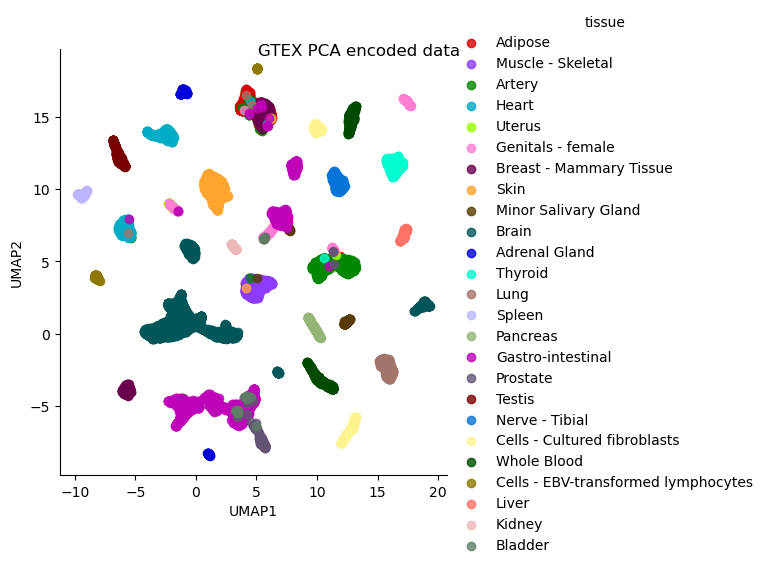

In [47]:
# GTEX PCA encoded data
plot_gtex_pca = sns.lmplot(x='UMAP1', y='UMAP2', data=proj_gtex_genes_pca_encoded, fit_reg=False, hue='tissue', legend=True, palette=sns.color_palette(cc.glasbey, n_colors=25))
fig = plot_gtex_pca.fig
fig.suptitle("GTEX PCA encoded data")
# plt.savefig(os.getcwd()+"/Figures/UMAP_PCA.png", dpi=300)